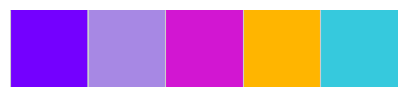

In [9]:
import os
import gc

import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
# Color Palette
custom_colors = ['#7400ff', '#a788e4', '#d216d2', '#ffb500', '#36c9dd']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [7]:
def distplot_features(df, feature, title, color = custom_colors[4], categorical=True):
    '''Takes a column from the dataframe and plots the distribution (after count)'''

    if categorical: values = df[feature].value_counts().values
    else: values = df[feature].values

    print('Mean: {:,}'.format(np.mean(values)), "\n"
          'Median: {:,}'.format(np.median(values)), "\n"
          'Max: {:,}'.format(np.max(values)))

    plt.figure(figsize = (18, 3))

    if categorical: sns.distplot(values, hist=False, color = color, kde_kws = {'lw':3})
    else:
        # To speed up the process
        if len(values) > 1000000: sns.distplot(values[::250000], hist=False, color = color, kde_kws = {'lw':3})
        else: sns.distplot(values, hist=False, color = color, kde_kws = {'lw':3})

    plt.title(title, fontsize=15)
    plt.show()    
    del values
    gc.collect()        

In [10]:
df = pd.read_csv('https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv')
print(clr.S+"CANCER DATASET:"+clr.E, df.shape)
df.head().style.background_gradient(cmap = "Oranges")

CANCER DATASET: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400000,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800000,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600000,2,0,2,1


In [4]:
df.shape, df.dtypes.value_counts(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       304 non-null    object
 1   1       304 non-null    object
 2   2       304 non-null    object
 3   3       304 non-null    object
 4   4       304 non-null    object
 5   5       304 non-null    object
 6   6       304 non-null    object
 7   7       304 non-null    object
 8   8       304 non-null    object
 9   9       304 non-null    object
 10  10      304 non-null    object
 11  11      304 non-null    object
 12  12      304 non-null    object
 13  13      304 non-null    object
dtypes: object(14)
memory usage: 33.4+ KB


((304, 14),
 object    14
 dtype: int64,
 None)

In [11]:
# Data Information
print("Rows: {:,}".format(len(df)), "\n" +
      "Columns: {}".format(len(df.columns)))

# Find Missing Data if any
total = len(df)

for column in df.columns:
    if df[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, df[column].isna().sum(), 
                                                             (df[column].isna().sum()/total)*100))
     

Rows: 303 
Columns: 14


In [6]:
vars_to_impute = [var for var in df.columns if df[var].isnull().sum() > 0]

vars_to_impute, df.isnull().mean()
     

([],
 0     0.0
 1     0.0
 2     0.0
 3     0.0
 4     0.0
 5     0.0
 6     0.0
 7     0.0
 8     0.0
 9     0.0
 10    0.0
 11    0.0
 12    0.0
 13    0.0
 dtype: float64)

In [12]:
# Split data into X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.84 0.85 0.82 0.8  0.77]
Accuracy mean: 0.81


**We used cross_val_score here, and we will use GridSearchCV to tune hyperparameters. Next, let's find a way to ensure that the test folds are the same using StratifiedKFold.**

#Baseline model


In [13]:
# Import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.72 0.82 0.75 0.8  0.82]
Accuracy mean: 0.78


$Combining GridSearchCV and RandomizedSearchCV

In [14]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [15]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params: {'n_estimators': 100}
Best score: 0.78235


In [16]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.05}
Best score: 0.79585


In [17]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 2}
Best score: 0.79902


In [18]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Best params: {'gamma': 0.5}
Best score: 0.79574


In [19]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Best params: {'min_child_weight': 5}
Best score: 0.81219


In [20]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.8}
Best score: 0.79579


#Applying early stopping
Early stopping is a general method to limit the number of training rounds in iterative machine learning algorithms. In this section, we look at eval_set, eval_metric, and early_stopping_rounds to apply early stopping.

What is early stopping?

# eval_set and eval_metric
early_stopping_rounds is not a hyperparameter, but a strategy for optimizing the n_estimators hyperparameter.

Normally when choosing hyperparameters, a test score is given after all boosting rounds are complete. To use early stopping, we need a test score after each round.

eval_metric and eval_set may be used as parameters for .fit to generate test scores for each training round. eval_metric provides the scoring method, commonly 'error' for classification, and 'rmse' for regression. eval_set provides the test to be evaluated, commonly X_test and y_test.

In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.15789
[1]	validation_0-error:0.10526
[2]	validation_0-error:0.11842
[3]	validation_0-error:0.13158
[4]	validation_0-error:0.11842
[5]	validation_0-error:0.14474
[6]	validation_0-error:0.14474
[7]	validation_0-error:0.14474
[8]	validation_0-error:0.14474
[9]	validation_0-error:0.14474
[10]	validation_0-error:0.14474
[11]	validation_0-error:0.15789
[12]	validation_0-error:0.15789
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.17105
[15]	validation_0-error:0.17105
[16]	validation_0-error:0.15789
[17]	validation_0-error:0.17105
[18]	validation_0-error:0.15789
[19]	validation_0-error:0.17105
[20]	validation_0-error:0.17105
[21]	validation_0-error:0.17105
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.17105
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-

In [22]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10, verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.15789
[1]	validation_0-error:0.10526
[2]	validation_0-error:0.11842
[3]	validation_0-error:0.13158
[4]	validation_0-error:0.11842
[5]	validation_0-error:0.14474
[6]	validation_0-error:0.14474
[7]	validation_0-error:0.14474
[8]	validation_0-error:0.14474
[9]	validation_0-error:0.14474
[10]	validation_0-error:0.14474
[11]	validation_0-error:0.15789
Accuracy: 89.47%


In [24]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight' :[1, 2, 3, 4, 5],'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth':[1, 2, 3, 4, 5, None],'n_estimators':[2, 25, 50, 75, 100]},random=True)

Best params: {'subsample': 0.6, 'n_estimators': 25, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.5}
Best score: 0.82208


# colsample_bytree
Similar to subsample, colsample_bytree randomly selects particular columns according to the given percentage. colsample_bytree is useful for limiting the influence of columns and reducing variance. Note that colsample_bytree takes a percentage as input

In [25]:
grid_search(params={'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 'max_depth':[1], 'n_estimators':[50]})

Best params: {'colsample_bytree': 1, 'max_depth': 1, 'n_estimators': 50}
Best score: 0.83869


In [26]:
grid_search(params={'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 'max_depth':[1], 'n_estimators':[50]})

Best params: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.7, 'colsample_bytree': 0.8, 'max_depth': 1, 'n_estimators': 50}
Best score: 0.84852


#gamma
The last hyperparameter that we will attempt to fine-tune is gamma. Here is a range of gamma values designed to reduce overfitting:

In [27]:
grid_search(params={'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3], 'colsample_bylevel':[0.9], 'colsample_bytree':[0.8], 'colsample_bynode':[0.5], 'max_depth':[1], 'n_estimators':[50]})

Best params: {'colsample_bylevel': 0.9, 'colsample_bynode': 0.5, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 1, 'n_estimators': 50}
Best score: 0.83536


XGBoost hyperparameter fine-tuning takes time to master, and you are well on your way. Fine-tuning hyperparameters is a key skill that separates machine learning experts from machine learning novices. Knowledge of XGBoost hyperparameters is not just useful, it's essential to get the most out of the machine learning models that you build.